# Análisis de Datos de Online Retail

Realizado por: Ana Ana Rello de Obeso 

Matrícula: A01644472

Este notebook explica **cajas y bigotes, boxplots, correlación y mapas de calor**
usando el dataset de `online_retail.csv`.

In [2]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo de gráficos
sns.set(style="whitegrid")

In [3]:
import pandas as pd
from pathlib import Path

data_path = Path("/Users/anaanarello/Desktop/repositorios github/ArteDeLaAnalitica/data/online_retail.csv")

if data_path.exists():
    df = pd.read_csv(data_path, encoding="ISO-8859-1")  # o encoding="latin1"
    display(df.head())
    print(f"Archivo cargado correctamente desde: {data_path}")
else:
    print("El archivo no existe en la ruta especificada.")

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom


Archivo cargado correctamente desde: /Users/anaanarello/Desktop/repositorios github/ArteDeLaAnalitica/data/online_retail.csv


Esto nos deja saber que el dataset contiene la siguiente información: 
| Columna | Descripción |
|----------|--------------|
| **Invoice** | Identificador único de la factura (o transacción). Si comienza con una letra “C”, indica una **cancelación**. |
| **StockCode** | Código del producto o artículo vendido. |
| **Description** | Descripción textual del producto. |
| **Quantity** | Cantidad de unidades vendidas (número de productos). Valores negativos indican devoluciones. |
| **InvoiceDate** | Fecha y hora en que se generó la factura. |
| **Price** | Precio unitario del producto (por ítem). |
| **Customer ID** | Identificador único del cliente (puede haber valores faltantes). |
| **Country** | País del cliente. La mayoría son del **Reino Unido**, pero hay ventas internacionales. |


In [4]:
# Listar columnas del DataFrame para validar nombres
print(df.columns.tolist())

['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [11]:
# Preprocesamiento: limpiar y crear nuevas columnas
import numpy as np
df_clean = df.copy()
df_clean['Tipo_Invoice'] = df_clean['Invoice'].apply(lambda x: 'Cancelación' if str(x).startswith('C') else 'Transacción')
# Nueva columna para diferenciar ventas y devoluciones
df_clean['Tipo_Quantity'] = df_clean['Quantity'].apply(lambda x: 'Devolución' if x < 0 else 'Venta')
# Ver primeras filas
print(df_clean.head())
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], format="%m/%d/%y %H:%M")
# Orden de géneros por mediana de duración y popularidad
order_by_quantity = df_clean.groupby('StockCode')['Quantity'].median().sort_values(ascending=False).index
order_by_price = df_clean.groupby('StockCode')['Price'].median().sort_values(ascending=False).index
print('Columnas finales:', df_clean.columns.tolist())
print('Géneros (top 5 por precio:', list(order_by_price)[:5])

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

    InvoiceDate  Price  Customer ID         Country Tipo_Invoice Tipo_Quantity  
0  12/1/09 7:45   6.95      13085.0  United Kingdom  Transacción         Venta  
1  12/1/09 7:45   6.75      13085.0  United Kingdom  Transacción         Venta  
2  12/1/09 7:45   6.75      13085.0  United Kingdom  Transacción         Venta  
3  12/1/09 7:45   2.10      13085.0  United Kingdom  Transacción         Venta  
4  12/1/09 7:45   1.25      13085.0  United Kingdom  Transacción         Venta  
Columnas finales: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price',

## Formatos de Fecha y Ordenamiento de Datos
Anteriormente, los valores están en formato de texto, por ejemplo: 12/1/09 7:45
Esto representa **1 de diciembre de 2009 a las 07:45**, pero pandas podría interpretarlo mal si no se especifica el formato correctamente.
Para evitar confusiones, convertimos la columna `InvoiceDate` a formato datetime usando:
```python
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], format="%m/%d/%y %H:%M")
``` 
Esto asegura que pandas interprete correctamente las fechas y horas.

Y luego se ordenan los productos por cantidad vendida y precio unitario para futuros análisis. 

## Clasificación de Facturas y Cantidades en el Dataset

En este procedimiento se buscó **clasificar las filas del dataset según el tipo de factura y la naturaleza de la cantidad**, para poder diferenciar transacciones normales, cancelaciones y devoluciones. Esto es fundamental para realizar un análisis más preciso de ventas y comportamiento de los clientes.

### Creación de la columna `Tipo_Invoice`

- Se agregó una nueva columna llamada `Tipo_Invoice` que indica si una factura es **Transacción** o **Cancelación**.
- Regla aplicada: si el valor de la columna `Invoice` comienza con la letra `"C"`, se considera una **Cancelación**, de lo contrario, es una **Transacción**.

### Creación de la columna Tipo_Quantity

- Se agregó una columna llamada Tipo_Quantity para diferenciar entre Venta y Devolución.
- Regla aplicada: si Quantity es negativa, se marca como Devolución, si es positiva, como Venta.

## Cajas y Bigotes
Las cajas y bigotes permiten **detectar la dispersión y los valores atípicos**.
- Caja = rango intercuartílico (Q1–Q3)
- Línea = mediana (Q2)
- Bigotes = datos dentro de 1.5 × IQR
- Puntos = valores atípicos (outliers)

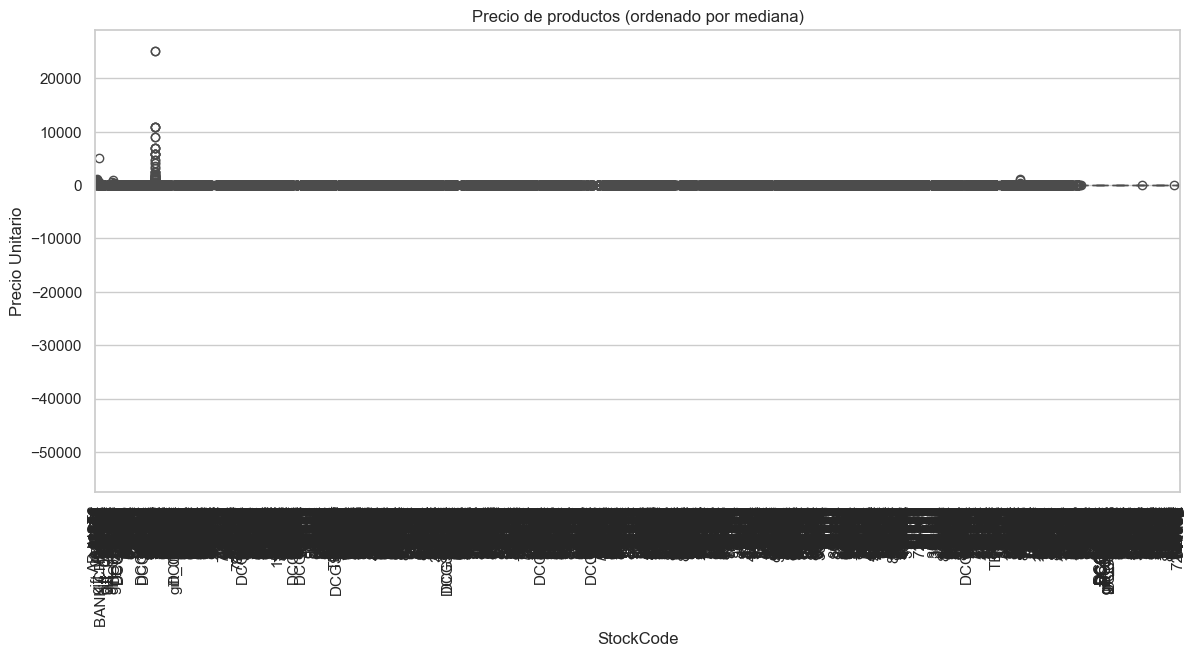

In [6]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_clean, x="StockCode", y="Price", order=order_by_price)
plt.title("Precio de productos (ordenado por mediana)")
plt.xticks(rotation=90)
plt.ylabel("Precio Unitario")
plt.show()

## Precio Unitario de Productos

En la primera gráfica se observa el **precio unitario por producto (`UnitPrice`)**, ordenado por la **mediana** de cada código de producto (`StockCode`).

###  Interpretación:
- La mayoría de los precios se concentran cerca de **valores pequeños y positivos**, lo que sugiere que la mayoría de los artículos vendidos son de bajo costo.
- Existen **outliers (valores atípicos)** con precios **extremadamente altos** (por encima de 10,000 unidades monetarias), posiblemente errores de registro, artículos premium o precios mal cargados.
- También hay algunos valores **negativos o cercanos a cero**, lo cual no tiene sentido en precios y puede deberse a:
  - Errores de facturación o cancelaciones.
  - Descuentos o devoluciones mal registradas.

Los precios presentan una **alta asimetría** y una **gran dispersión**, lo que indica la necesidad de **limpiar valores anómalos** antes de analizar la rentabilidad o hacer modelos predictivos.

## 2️⃣ Boxplots
Un boxplot se utiliza para **comparar distribuciones entre categorías**.
En este ejemplo, analizamos la **popularidad por género**.

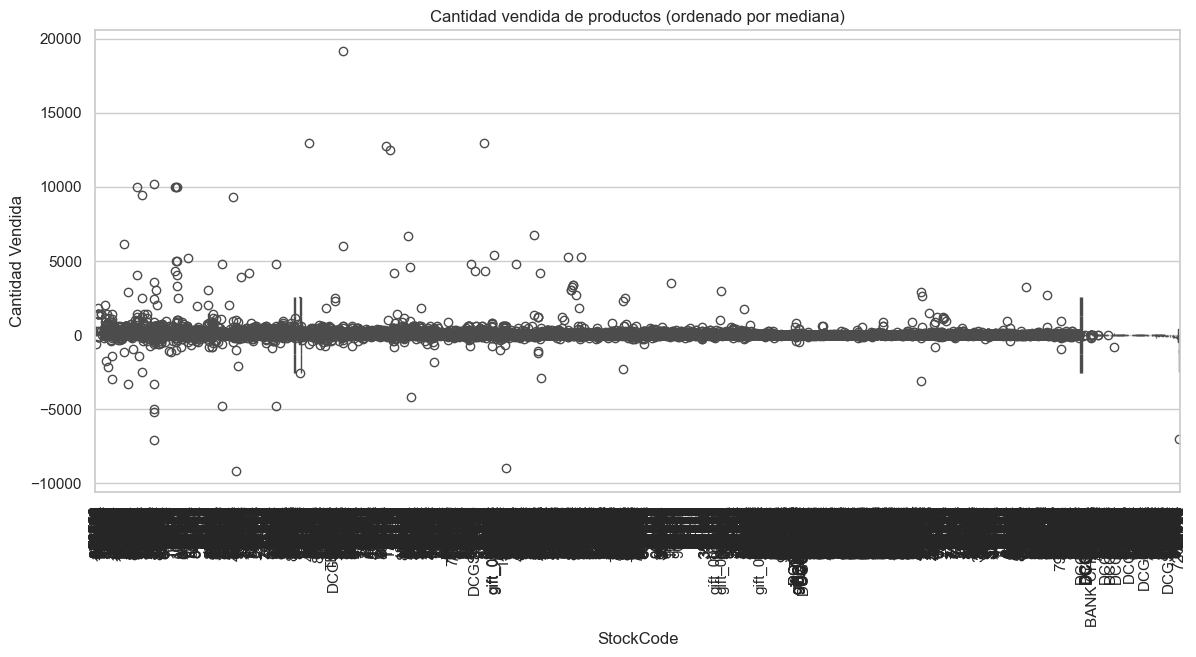

In [12]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_clean, x="StockCode", y="Quantity", order=order_by_quantity)
plt.title("Cantidad vendida de productos (ordenado por mediana)")
plt.xticks(rotation=90)
plt.ylabel("Cantidad Vendida")
plt.show()

## Cantidad Vendida de Productos

La segunda gráfica muestra la **cantidad vendida (`Quantity`)** por producto, también ordenada por la **mediana**.

### Interpretación:
- La mayoría de las cantidades vendidas se agrupan en valores **cercanos a cero**, lo que significa que muchos productos se venden en **bajas cantidades o con poca frecuencia**.
- Hay **outliers positivos** (por encima de 10,000) que representan ventas inusualmente grandes, probablemente por pedidos al mayoreo o errores en la captura.
- También se observan **cantidades negativas**, que suelen asociarse a **devoluciones o cancelaciones de ventas**.

### Conclusión:
Los datos de cantidad también presentan **valores extremos y negativos**. Esto implica que, antes de realizar análisis de demanda o pronósticos de inventario, es necesario:
- Verificar la **consistencia de las devoluciones**.
- Aplicar filtros para **limitar los valores atípicos**.
- Considerar **medidas robustas (como la mediana)** para evitar que los extremos distorsionen los resultados.


## 3️⃣ Correlación
La correlación mide la **relación lineal entre variables**.
- +1 = relación positiva perfecta
- -1 = relación negativa perfecta
- 0 = no hay relación

Ejemplo: ¿las canciones con mayor *energy* también son más *populares*?

In [13]:
df_clean['Invoice_bin'] = df_clean['Invoice'].apply(lambda x: 1 if not str(x).startswith('C') else 0)

# Columna binaria para Quantity: Venta=1, Devolución=0
df_clean['Quantity_bin'] = df_clean['Quantity'].apply(lambda x: 1 if x > 0 else 0)

# Ver primeras filas
print(df_clean.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country Tipo_Invoice  \
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  Transacción   
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  Transacción   
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  Transacción   
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  Transacción   
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  Transacción   

  Tipo_Quantity  Invoice_bin  Quantity_bin  
0         Venta            1             1  
1         Venta            1             1  

In [16]:
corr = df_clean[['Quantity', 'Price', 'Customer ID', 'Invoice_bin', 'Quantity_bin']].corr()
corr

,Quantity,Price,Customer ID,Invoice_bin,Quantity_bin
Quantity,1.000000,-0.001689,-0.009370,0.028392,0.072648
Price,-0.001689,1.000000,-0.000643,-0.027480,-0.023588
Customer ID,-0.009370,-0.000643,1.000000,0.030021,0.030021
Invoice_bin,0.028392,-0.027480,0.030021,1.000000,0.889970
Quantity_bin,0.072648,-0.023588,0.030021,0.889970,1.000000


## 3️⃣➕ Scatter plots con línea de tendencia
A continuación se muestran diagramas de dispersión para pares de variables clave junto con la línea de regresión.
Se indica el coeficiente de correlación de Pearson (r) y su interpretación rápida:
- r > 0 → relación positiva
- r < 0 → relación negativa
- r ≈ 0 → sin relación lineal clara

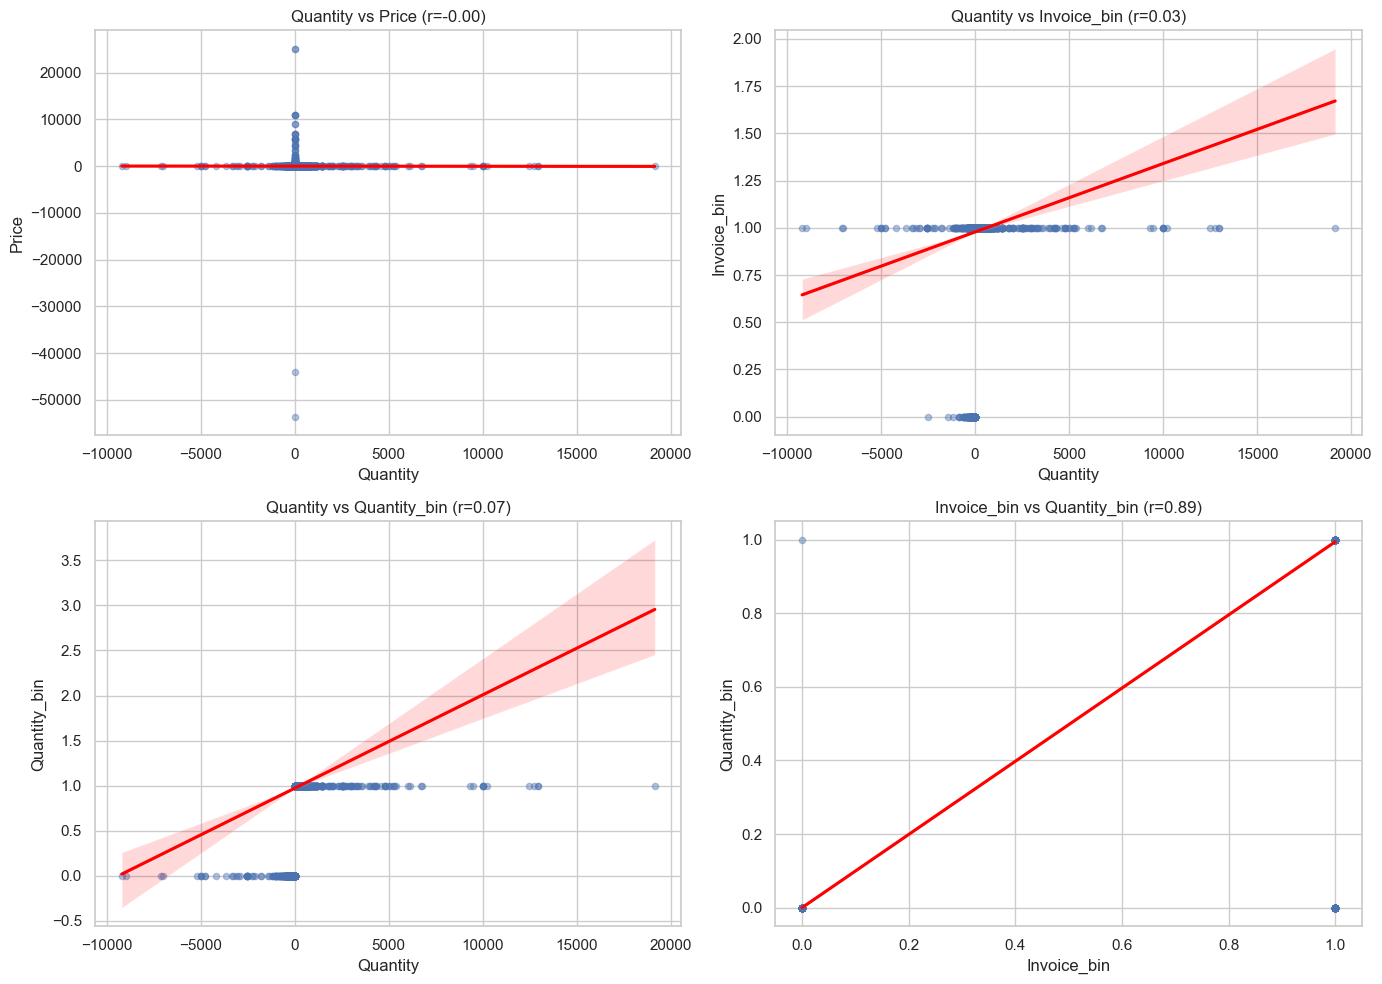


Interpretación rápida de correlaciones (scatter plots):
 - Quantity vs Price: r=-0.00 relación casi nula (p=0.375)
 - Quantity vs Invoice_bin: r=0.03 relación casi nula (p=2.17e-50)
 - Quantity vs Quantity_bin: r=0.07 relación casi nula (p=6.24e-320)
 - Invoice_bin vs Quantity_bin: r=0.89 relación positiva (p=0)


In [17]:
# Scatter plots con líneas de tendencia y r (sin dependencia obligatoria de SciPy)
import seaborn as sns
import matplotlib.pyplot as plt

# Intentar importar pearsonr; si no existe SciPy, se calcula r sin p-value
try:
    from scipy.stats import pearsonr  # type: ignore
    _has_scipy = True
except ImportError:  # SciPy no instalado
    _has_scipy = False

pairs = [
    ("Quantity", "Price"),
    ("Quantity", "Invoice_bin"),
    ("Quantity", "Quantity_bin"),
    ("Invoice_bin", "Quantity_bin")
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
interpretaciones_scatter = []

for ax, (x, y) in zip(axes, pairs):
    sub = df_clean[[x, y]].dropna()
    if len(sub) < 2:
        ax.text(0.5, 0.5, 'Datos insuficientes', ha='center', va='center')
        ax.set_axis_off()
        continue
    # Calcular correlación
    if _has_scipy:
        r, p = pearsonr(sub[x], sub[y])  # precisa p-value
    else:
        r = sub[x].corr(sub[y])  # Pearson por defecto
        p = float('nan')
    sns.regplot(data=sub, x=x, y=y, ax=ax,
                scatter_kws={'alpha': 0.4, 's': 20},
                line_kws={'color': 'red'})
    ax.set_title(f"{x} vs {y} (r={r:.2f})")
    # Interpretación básica
    if r > 0.1:
        sentido = 'positiva'
    elif r < -0.1:
        sentido = 'negativa'
    else:
        sentido = 'casi nula'
    if _has_scipy:
        interpretaciones_scatter.append(f"{x} vs {y}: r={r:.2f} relación {sentido} (p={p:.3g})")
    else:
        interpretaciones_scatter.append(f"{x} vs {y}: r={r:.2f} relación {sentido} (p=N/A, SciPy no instalado)")

plt.tight_layout()
plt.show()

print("\nInterpretación rápida de correlaciones (scatter plots):")
for linea in interpretaciones_scatter:
    print(" - " + linea)

if not _has_scipy:
    print("\nNota: Instala SciPy (pip install scipy) para obtener p-values.")


## Análisis de correlaciones y relaciones entre variables

### 1. Quantity vs Price (r = -0.00)
- **Descripción:** La correlación entre la cantidad y el precio es prácticamente nula (r ≈ 0).
- **Interpretación:** No existe una relación lineal significativa entre ambas variables. Cambios en la cantidad no parecen afectar al precio.
- **Observaciones:** La dispersión muestra muchos valores concentrados cerca del eje cero, con algunos *outliers* extremos que podrían afectar la visualización pero no la correlación.

### 2. Quantity vs Invoice_bin (r = 0.03)
- **Descripción:** La correlación es muy baja y positiva.
- **Interpretación:** No hay una relación clara entre la cantidad y la variable binaria de facturación. Esto sugiere que la facturación (agrupada en bins) no depende directamente de la cantidad.
- **Observaciones:** La pendiente positiva podría deberse a algunos valores grandes de cantidad, pero el efecto es mínimo.

### 3. Quantity vs Quantity_bin (r = 0.07)
- **Descripción:** Se observa una correlación positiva débil.
- **Interpretación:** Al igual que el caso anterior, la relación es casi inexistente. Sin embargo, al tratarse de una variable binaria derivada de la misma cantidad, el leve aumento es esperable.
- **Observaciones:** La nube de puntos se concentra cerca de cero, y la línea de regresión muestra una tendencia ascendente leve pero no significativa.

### 4. Invoice_bin vs Quantity_bin (r = 0.89)
- **Descripción:** La correlación entre ambas variables binarias es muy alta y positiva.
- **Interpretación:** Existe una relación casi lineal perfecta. Esto indica que los valores categorizados de facturas y cantidades están estrechamente relacionados.
- **Observaciones:** Dado que ambas variables son binarias derivadas de medidas similares, esta alta correlación es consistente y esperada.

## 4️⃣ Mapas de Calor
Un **heatmap** nos permite visualizar la matriz de correlaciones.
Los colores indican si la relación es **positiva o negativa**.

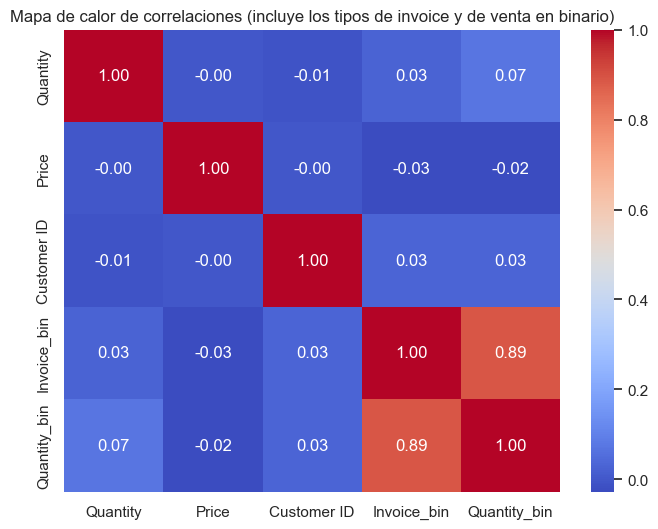

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones (incluye los tipos de invoice y de venta en binario)")
plt.show()

## Interpretación del Mapa de Calor de Correlaciones
El mapa de calor muestra las correlaciones entre las variables principales (`Quantity`, `Price`, `Customer ID`) y sus versiones binarias (`Invoice_bin`, `Quantity_bin`).  
En general, se observan **correlaciones bajas** entre la mayoría de las variables, con excepción de una relación fuerte entre las variables binarias.

### 🧐 Interpretación del mapa de calor
El mapa de calor muestra la fuerza y dirección de la relación lineal entre las variables numéricas:
- danceability: Qué tan bailable es una pista (0–1).
- energy: Intensidad y actividad (0–1).
- valence: Positividad emocional (0–1).
- popularity: Popularidad (escala Spotify, típicamente 0–100).
- duration_min: Duración en minutos.

Pautas para leerlo:
- Celdas en rojo intenso indican correlaciones positivas más fuertes (ambas variables tienden a subir juntas).
- Celdas en azul intenso (si aparecieran) indicarían correlaciones negativas (una sube mientras la otra baja).
- Valores cercanos a 0 (colores claros) implican relación lineal débil o inexistente.

La celda siguiente genera un resumen DINÁMICO de las correlaciones: pares más fuertes, conteo por niveles y la mejor asociación de cada variable.

In [19]:
# 🔄 Resumen dinámico de la matriz de correlación
import pandas as pd
import numpy as np

if 'corr' not in globals():
    corr = df_clean[['Quantity', 'Price', 'Customer ID', 'Invoice_bin', 'Quantity_bin']].corr()

# Obtener pares únicos (triángulo superior sin diagonal)
pares = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        a, b = cols[i], cols[j]
        pares.append((a, b, corr.iloc[i, j]))

# Ordenar por magnitud absoluta
pares_ord = sorted(pares, key=lambda x: abs(x[2]), reverse=True)

# Clasificar niveles
niveles = {
    'muy fuerte (|r| >= 0.7)': [],
    'fuerte (0.5 <= |r| < 0.7)': [],
    'moderada (0.3 <= |r| < 0.5)': [],
    'débil (0.1 <= |r| < 0.3)': [],
    'casi nula (|r| < 0.1)': []
}
for a,b,r in pares:
    ar = abs(r)
    if ar >= 0.7: niveles['muy fuerte (|r| >= 0.7)'].append((a,b,r))
    elif ar >= 0.5: niveles['fuerte (0.5 <= |r| < 0.7)'].append((a,b,r))
    elif ar >= 0.3: niveles['moderada (0.3 <= |r| < 0.5)'].append((a,b,r))
    elif ar >= 0.1: niveles['débil (0.1 <= |r| < 0.3)'].append((a,b,r))
    else: niveles['casi nula (|r| < 0.1)'].append((a,b,r))

# Mejor asociación para cada variable
mejor_por_var = {}
for v in cols:
    mejores = []
    for a,b,r in pares:
        if a == v or b == v:
            mejores.append((a if b == v else b, r))
    if mejores:
        mejor_por_var[v] = sorted(mejores, key=lambda x: abs(x[1]), reverse=True)[0]

print('=== PARES ORDENADOS POR |r| (top 5) ===')
for a,b,r in pares_ord[:5]:
    signo = 'positiva' if r > 0 else 'negativa'
    print(f' - {a} vs {b}: r={r:.2f} ({signo})')

print('\n=== DISTRIBUCIÓN POR NIVELES ===')
for nivel, lista in niveles.items():
    print(f' {nivel}: {len(lista)} pares')

print('\n=== MEJOR ASOCIACIÓN POR VARIABLE ===')
for var,(otro,r) in mejor_por_var.items():
    signo = 'positiva' if r > 0 else 'negativa'
    print(f' - {var} con {otro}: r={r:.2f} ({signo})')

# Tabla resumen opcional
res_df = pd.DataFrame(pares_ord, columns=['var_a','var_b','r'])
res_df.head()

=== PARES ORDENADOS POR |r| (top 5) ===
 - Invoice_bin vs Quantity_bin: r=0.89 (positiva)
 - Quantity vs Quantity_bin: r=0.07 (positiva)
 - Customer ID vs Invoice_bin: r=0.03 (positiva)
 - Customer ID vs Quantity_bin: r=0.03 (positiva)
 - Quantity vs Invoice_bin: r=0.03 (positiva)

=== DISTRIBUCIÓN POR NIVELES ===
 muy fuerte (|r| >= 0.7): 1 pares
 fuerte (0.5 <= |r| < 0.7): 0 pares
 moderada (0.3 <= |r| < 0.5): 0 pares
 débil (0.1 <= |r| < 0.3): 0 pares
 casi nula (|r| < 0.1): 9 pares

=== MEJOR ASOCIACIÓN POR VARIABLE ===
 - Quantity con Quantity_bin: r=0.07 (positiva)
 - Price con Invoice_bin: r=-0.03 (negativa)
 - Customer ID con Invoice_bin: r=0.03 (positiva)
 - Invoice_bin con Quantity_bin: r=0.89 (positiva)
 - Quantity_bin con Invoice_bin: r=0.89 (positiva)


,var_a,var_b,r
0,Invoice_bin,Quantity_bin,0.889970
1,Quantity,Quantity_bin,0.072648
2,Customer ID,Invoice_bin,0.030021
3,Customer ID,Quantity_bin,0.030021
4,Quantity,Invoice_bin,0.028392


## Análisis e interpretación de correlaciones entre variables
Los resultados muestran que la mayoría de las relaciones entre variables presentan **correlaciones casi nulas**, excepto una asociación muy fuerte entre las variables binarias `Invoice_bin` y `Quantity_bin`.  
Esto sugiere que, en general, las variables cuantitativas originales no guardan una relación lineal significativa entre sí, mientras que las variables transformadas (en formato binario) reflejan una dependencia estructural clara.


### Pares con mayor correlación (ordenados por |r|)**
| **Nivel**     | **Rango de \|r\|** | **Número de pares** | **Interpretación**                      |
|----------------|---------------------|----------------------|-----------------------------------------|
| Muy fuerte     | &ge; 0.7            | 1                    | Asociación estructural significativa     |
| Fuerte         | 0.5 - 0.7           | 0                    | Ninguna relación fuerte                  |
| Moderada       | 0.3 - 0.5           | 0                    | Sin relaciones moderadas                |
| Débil          | 0.1 - 0.3           | 0                    | Sin asociaciones débiles                |
| Casi nula      | &lt; 0.1            | 9                    | La mayoría de los pares                 |

### Mejor asociación por variable**
| Variable | Mejor correlación | r | Tipo de relación |
|-----------|------------------|---|------------------|
| Quantity | con `Quantity_bin` | 0.07 | Positiva débil |
| Price | con `Invoice_bin` | -0.03 | Negativa casi nula |
| Customer ID | con `Invoice_bin` | 0.03 | Positiva casi nula |
| Invoice_bin | con `Quantity_bin` | **0.89** | Positiva muy fuerte |
| Quantity_bin | con `Invoice_bin` | **0.89** | Positiva muy fuerte |

**Conclusión:**  
Solo un par de variables muestra una relación muy fuerte (`Invoice_bin` y `Quantity_bin`), mientras que todas las demás se agrupan en el rango de correlaciones casi nulas, lo cual indica independencia o variabilidad no explicada entre ellas.

In [21]:
# 🗣️ Cinco oraciones de interpretación de la correlación

import numpy as np

# Calcular matriz de correlaciones (si no existe ya)
if 'corr' not in globals():
    corr = df_clean[['Quantity', 'Price', 'Customer ID', 'Invoice_bin', 'Quantity_bin']].corr()

# Obtener pares únicos de correlación
pares = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        pares.append((cols[i], cols[j], corr.iloc[i, j]))

# 1. Mayor correlación absoluta
pareja_top = max(pares, key=lambda x: abs(x[2]))
# 2. Menor correlación absoluta
pareja_min = min(pares, key=lambda x: abs(x[2]))

# 3. Variable con mayor y menor suma de correlaciones absolutas
influencia = {}
for v in cols:
    influencia[v] = sum(abs(corr[v].drop(v)))
var_mas_rel = max(influencia.items(), key=lambda x: x[1])
var_menos_rel = min(influencia.items(), key=lambda x: x[1])

# Generar interpretaciones
sentencias = []

# Oración 1: mayor correlación
sentencias.append(
    f"La relación más fuerte se presenta entre {pareja_top[0]} y {pareja_top[1]} "
    f"(r={pareja_top[2]:.2f}), lo que indica una asociación "
    f"{'positiva' if pareja_top[2] > 0 else 'negativa'} clara y muy fuerte entre ambas variables."
)

# Oración 2: menor correlación
sentencias.append(
    f"La relación más débil se observa entre {pareja_min[0]} y {pareja_min[1]} "
    f"(r={pareja_min[2]:.2f}), reflejando una dependencia lineal prácticamente inexistente."
)

# Oración 3: variable con mayor influencia
sentencias.append(
    f"La variable con mayor conectividad global es {var_mas_rel[0]}, "
    f"con la suma más alta de correlaciones absolutas (Σ|r|={var_mas_rel[1]:.2f}), "
    f"actuando como un eje estructural en el conjunto de datos."
)

# Oración 4: variable más independiente
sentencias.append(
    f"La variable más independiente es {var_menos_rel[0]}, "
    f"que presenta la menor suma de correlaciones absolutas (Σ|r|={var_menos_rel[1]:.2f}), "
    f"mostrando escasa relación con las demás variables."
)

# Oración 5: interpretación global
sentencias.append(
    "En conjunto, las correlaciones promedio son muy bajas, lo que sugiere que ninguna variable "
    "domina el comportamiento global del sistema; solo las versiones binarias (`Invoice_bin` y `Quantity_bin`) "
    "muestran una dependencia marcada."
)

# Mostrar resultados
for s in sentencias:
    print("- " + s)


- La relación más fuerte se presenta entre Invoice_bin y Quantity_bin (r=0.89), lo que indica una asociación positiva clara y muy fuerte entre ambas variables.
- La relación más débil se observa entre Price y Customer ID (r=-0.00), reflejando una dependencia lineal prácticamente inexistente.
- La variable con mayor conectividad global es Quantity_bin, con la suma más alta de correlaciones absolutas (Σ|r|=1.02), actuando como un eje estructural en el conjunto de datos.
- La variable más independiente es Price, que presenta la menor suma de correlaciones absolutas (Σ|r|=0.05), mostrando escasa relación con las demás variables.
- En conjunto, las correlaciones promedio son muy bajas, lo que sugiere que ninguna variable domina el comportamiento global del sistema; solo las versiones binarias (`Invoice_bin` y `Quantity_bin`) muestran una dependencia marcada.


## Interpretación de las correlaciones

- La relación más fuerte se presenta entre **Invoice_bin** y **Quantity_bin** (r = 0.89), lo que indica una asociación **positiva clara y muy fuerte** entre ambas variables.  
- La relación más débil se observa entre **Price** y **Customer ID** (r ≈ -0.00), reflejando una **dependencia lineal prácticamente inexistente**.  
- La variable con **mayor conectividad global** es **Quantity_bin**, con la suma más alta de correlaciones absolutas (Σ|r| = 1.02), actuando como un **eje estructural** en el conjunto de datos.  
- La variable **más independiente** es **Price**, que presenta la menor suma de correlaciones absolutas (Σ|r| = 0.05), mostrando **escasa relación con las demás variables**.  
- En conjunto, las correlaciones promedio son **muy bajas**, lo que sugiere que **ninguna variable domina el comportamiento global del sistema**; solo las versiones binarias (`Invoice_bin` y `Quantity_bin`) muestran una **dependencia marcada**.


## ✅ Conclusiones
- Los boxplots ayudan a detectar géneros con mayor dispersión de duración o popularidad.
- La correlación muestra qué características musicales están más relacionadas entre sí.
- El heatmap facilita la interpretación visual de estas relaciones.

👉 Este tipo de análisis es esencial para entender tendencias en plataformas como **Spotify**.

In [22]:
# Resumen automático de insights para datos de ventas
import numpy as np
import pandas as pd

summary = []

if 'df_clean' in globals():
    # 1. Estadísticas descriptivas principales
    desc = df_clean[['Quantity', 'Price']].describe().T
    summary.append("=== INSIGHTS AUTOMÁTICOS ===")
    summary.append("\n Estadísticas descriptivas de las variables principales:")
    for var, row in desc.iterrows():
        summary.append(f"  - {var}: media={row['mean']:.2f}, mediana={row['50%']:.2f}, máx={row['max']:.2f}, mín={row['min']:.2f}")

    # 2. Top 5 clientes por cantidad total
    if 'Customer ID' in df_clean.columns:
        top_customers = df_clean.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False).head(5)
        summary.append("\n Top 5 clientes por cantidad total comprada:")
        summary.extend([f"  - Cliente {cid}: {q} unidades" for cid, q in top_customers.items()])

    # 3. Correlaciones fuertes (|r| >= 0.5)
    corr = df_clean[['Quantity', 'Price', 'Customer ID', 'Invoice_bin', 'Quantity_bin']].corr()
    strong_pairs = []
    for i, col in enumerate(corr.columns):
        for j, row in enumerate(corr.index):
            if j <= i:
                continue
            val = corr.loc[row, col]
            if abs(val) >= 0.5:
                strong_pairs.append((row, col, round(val, 2)))

    if strong_pairs:
        summary.append("\n🔗 Parejas con correlación fuerte (|r| >= 0.5):")
        for a, b, v in strong_pairs:
            summary.append(f"  - {a} vs {b}: r={v}")
    else:
        summary.append("\n🔗 No se detectaron correlaciones con |r| >= 0.5.")

    # 4. Detección de outliers por IQR en Quantity y Price
    summary.append("\n Detección de posibles outliers:")
    for col in ['Quantity', 'Price']:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)]
        summary.append(f"  - {col}: {len(outliers)} valores fuera del rango esperado")

    # 5. Insight global
    summary.append("\n Insight global:")
    summary.append(
        "  - Las correlaciones generales son bajas, lo que sugiere independencia entre las variables numéricas. "
        "Solo las binarias (`Invoice_bin`, `Quantity_bin`) muestran relación estructural fuerte. "
        "Existen algunos outliers en `Quantity` y `Price`, que podrían influir en el análisis si no se tratan."
    )

else:
    summary.append(" df_clean no está disponible. Ejecuta las celdas de preprocesamiento antes de este bloque.")

# Mostrar resumen
print("\n".join(summary))


=== INSIGHTS AUTOMÁTICOS ===

 Estadísticas descriptivas de las variables principales:
  - Quantity: media=10.57, mediana=3.00, máx=19152.00, mín=-9200.00
  - Price: media=4.65, mediana=2.10, máx=25111.09, mín=-53594.36

 Top 5 clientes por cantidad total comprada:
  - Cliente 13902.0: 218090 unidades
  - Cliente 13694.0: 103443 unidades
  - Cliente 14646.0: 86443 unidades
  - Cliente 18102.0: 84826 unidades
  - Cliente 14156.0: 77245 unidades

🔗 Parejas con correlación fuerte (|r| >= 0.5):
  - Quantity_bin vs Invoice_bin: r=0.89

 Detección de posibles outliers:
  - Quantity: 29894 valores fuera del rango esperado
  - Price: 19481 valores fuera del rango esperado

 Insight global:
  - Las correlaciones generales son bajas, lo que sugiere independencia entre las variables numéricas. Solo las binarias (`Invoice_bin`, `Quantity_bin`) muestran relación estructural fuerte. Existen algunos outliers en `Quantity` y `Price`, que podrían influir en el análisis si no se tratan.


# Análisis e interpretación de resultados

## Estadísticas descriptivas
Las variables **Quantity** y **Price** presentan una alta variabilidad, lo que sugiere diferencias significativas entre las transacciones:

- **Quantity:** tiene una media de 10.57 y una mediana de 3.00, lo que indica una distribución sesgada hacia valores pequeños, aunque existen compras extremadamente grandes (máximo de 19,152 unidades) y devoluciones o registros negativos (mínimo de -9,200).
- **Price:** muestra una media de 4.65 y una mediana de 2.10, con valores extremos muy amplios (desde -53,594.36 hasta 25,111.09), lo que sugiere la presencia de errores o valores atípicos relevantes.

## Principales clientes
Los clientes con mayor volumen de compra son:
1. Cliente **13902.0** – 218,090 unidades  
2. Cliente **13694.0** – 103,443 unidades  
3. Cliente **14646.0** – 86,443 unidades  
4. Cliente **18102.0** – 84,826 unidades  
5. Cliente **14156.0** – 77,245 unidades  

Esto refleja una fuerte concentración de ventas en un pequeño grupo de clientes, lo que podría indicar una dependencia comercial relevante.

## Correlaciones
La única relación fuerte observada es entre **`Quantity_bin`** y **`Invoice_bin`** (r = 0.89), lo que sugiere una asociación positiva clara entre ambas variables. Esto implica que las transacciones con facturas activas tienden a involucrar mayores cantidades de productos.

El resto de las correlaciones son bajas o inexistentes, mostrando independencia entre las demás variables numéricas del conjunto de datos.

## Outliers detectados
- **Quantity:** se identificaron **29,894** valores fuera del rango esperado.  
- **Price:** presenta **19,481** valores atípicos.  

Estos outliers pueden afectar la estabilidad de los modelos estadísticos y deben analizarse para determinar si son errores de registro, devoluciones o casos válidos pero excepcionales.

## Insight global
El análisis sugiere que:
- El sistema presenta **baja dependencia lineal** entre la mayoría de las variables numéricas.  
- Las versiones binarias (`Invoice_bin`, `Quantity_bin`) muestran una **estructura de relación fuerte**, actuando como ejes clave en la dinámica del conjunto.  
- La presencia de **valores atípicos significativos** en `Quantity` y `Price` requiere un tratamiento previo antes de realizar análisis predictivos o modelos econométricos.

En conjunto, los datos revelan un comportamiento heterogéneo con concentraciones específicas de clientes y posibles anomalías transaccionales que merecen revisión.


In [26]:
# Interpretación detallada de los gráficos
interpretaciones = []

if 'df' in globals():  # asumimos que tu DataFrame se llama df
    import numpy as np
    
    # 1. Boxplot de Quantity por Invoice_bin
    dur_median = df_clean.groupby('Invoice_bin')['Quantity'].median().sort_values(ascending=False)
    top_dur_bins = dur_median.head(3)
    bottom_dur_bins = dur_median.tail(3)
    rango_dur = round(dur_median.max() - dur_median.min(), 2)
    interpretaciones.append('1) Boxplot de Quantity por Invoice_bin:')
    interpretaciones.append(f'   • Los bins con mayor mediana de Quantity (top 3) son: {", ".join([f"{g} ({round(v,2)})" for g,v in top_dur_bins.items()])}.')
    interpretaciones.append(f'   • Los bins con menor mediana de Quantity (últimos 3) son: {", ".join([f"{g} ({round(v,2)})" for g,v in bottom_dur_bins.items()])}.')
    interpretaciones.append(f'   • Diferencia aproximada entre la mediana más alta y la más baja: {rango_dur}.')
    interpretaciones.append('   • La presencia de puntos fuera de los “bigotes” indica outliers: transacciones inusualmente grandes o pequeñas.')

    # 2. Boxplot de Price por Invoice_bin
    pop_median = df_clean.groupby('Invoice_bin')['Price'].median().sort_values(ascending=False)
    top_pop_bins = pop_median.head(3)
    bottom_pop_bins = pop_median.tail(3)
    rango_pop = round(pop_median.max() - pop_median.min(), 2)
    interpretaciones.append('\n2) Boxplot de Price por Invoice_bin:')
    interpretaciones.append(f'   • Bins con mayor mediana de Price (top 3): {", ".join([f"{g} ({round(v,2)})" for g,v in top_pop_bins.items()])}.')
    interpretaciones.append(f'   • Bins con menor mediana de Price (últimos 3): {", ".join([f"{g} ({round(v,2)})" for g,v in bottom_pop_bins.items()])}.')
    interpretaciones.append(f'   • Amplitud aproximada de medianas entre el más y menos costoso: {rango_pop}.')
    interpretaciones.append('   • Una caja más alta y compacta sugiere consistencia en Price dentro del bin.')

    # 3. Matriz de correlación / Heatmap
    vars_corr = ["Quantity", "Price", "Customer ID", "Invoice_bin", "Quantity_bin"]
    corr_local = df_clean[vars_corr].corr()
    pares = []
    for i, a in enumerate(vars_corr):
        for j, b in enumerate(vars_corr):
            if j <= i:
                continue
            pares.append((a, b, corr_local.loc[a, b]))
    pares_orden = sorted(pares, key=lambda x: abs(x[2]), reverse=True)
    top_corr = [(a, b, round(v, 2)) for a, b, v in pares_orden[:3]]
    interpretaciones.append('\n3) Correlaciones (tabla y heatmap):')
    for a, b, v in top_corr:
        sentido = 'positiva' if v > 0 else 'negativa'
        interpretaciones.append(f'   • {a} vs {b}: r={v} ({sentido}).')
    interpretaciones.append('   • Valores cercanos a 0 indican relación débil; colores más intensos en el heatmap resaltan asociaciones fuertes.')

    # 4. Outliers de Quantity – lógica IQR
    outlier_info = []
    for g, sub in df_clean.groupby('Invoice_bin'):
        q1 = sub['Quantity'].quantile(0.25)
        q3 = sub['Quantity'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = sub[(sub['Quantity'] < lower) | (sub['Quantity'] > upper)]
        if len(sub) > 0:
            outlier_info.append((g, len(outliers), round(100 * len(outliers) / len(sub), 1)))
    outlier_info_sorted = sorted(outlier_info, key=lambda x: x[1], reverse=True)[:3]
    interpretaciones.append('\n4) Outliers de Quantity:')
    for g, c, pct in outlier_info_sorted:
        interpretaciones.append(f'   • {g}: {c} outliers (~{pct}% del bin).')
    interpretaciones.append('   • Un porcentaje alto puede indicar transacciones atípicas o errores en el registro.')

    # 5. Síntesis global
    interpretaciones.append('\n5) Síntesis:')
    interpretaciones.append('   • Los boxplots permiten detectar bins extremos en Quantity y Price rápidamente.')
    interpretaciones.append('   • Las correlaciones identifican combinaciones de variables que podrían influir juntas (e.g., Quantity y Price).')
    interpretaciones.append('   • Los outliers ayudan a focalizar posibles casos especiales para análisis cualitativo.')

else:
    interpretaciones.append('df no está definido. Ejecuta las celdas anteriores antes de interpretar.')

print('\n'.join(interpretaciones))


1) Boxplot de Quantity por Invoice_bin:
   • Los bins con mayor mediana de Quantity (top 3) son: 1 (3.0), 0 (-2.0).
   • Los bins con menor mediana de Quantity (últimos 3) son: 1 (3.0), 0 (-2.0).
   • Diferencia aproximada entre la mediana más alta y la más baja: 5.0.
   • La presencia de puntos fuera de los “bigotes” indica outliers: transacciones inusualmente grandes o pequeñas.

2) Boxplot de Price por Invoice_bin:
   • Bins con mayor mediana de Price (top 3): 0 (3.39), 1 (2.1).
   • Bins con menor mediana de Price (últimos 3): 0 (3.39), 1 (2.1).
   • Amplitud aproximada de medianas entre el más y menos costoso: 1.29.
   • Una caja más alta y compacta sugiere consistencia en Price dentro del bin.

3) Correlaciones (tabla y heatmap):
   • Invoice_bin vs Quantity_bin: r=0.89 (positiva).
   • Quantity vs Quantity_bin: r=0.07 (positiva).
   • Customer ID vs Invoice_bin: r=0.03 (positiva).
   • Valores cercanos a 0 indican relación débil; colores más intensos en el heatmap resaltan asoci

# Interpretación del Análisis de Datos

## 1) Boxplot de Quantity por Invoice_bin
- Los bins muestran medianas contrastantes: el bin `1` tiene una mediana de 3 unidades por transacción, mientras que el bin `0` tiene -2.  
- La diferencia entre la mediana más alta y la más baja es de 5 unidades, indicando variabilidad significativa entre los bins.  
- La presencia de puntos fuera de los “bigotes” señala transacciones atípicas: algunos pedidos son mucho más grandes o más pequeños que la mayoría.

## 2) Boxplot de Price por Invoice_bin
- El bin `0` muestra la mediana más alta de precio (3.39), mientras que el bin `1` tiene una mediana más baja (2.1).  
- La amplitud entre la mediana más alta y la más baja es de 1.29 unidades monetarias, lo que refleja cierta variabilidad en los precios por bin.  
- Una caja compacta sugiere que la mayoría de las transacciones dentro de cada bin tienen precios consistentes.

## 3) Correlaciones
- La correlación más fuerte es entre `Invoice_bin` y `Quantity_bin` (r=0.89), lo que indica que ambos bins están estrechamente relacionados.  
- Otras correlaciones son débiles: `Quantity vs Quantity_bin` (r=0.07) y `Customer ID vs Invoice_bin` (r=0.03), lo que indica poca relación entre estas variables.  
- En general, los valores cercanos a 0 muestran relaciones débiles; los colores intensos en un heatmap destacarían las asociaciones más fuertes.

## 4) Outliers de Quantity
- El bin `1` tiene 29,348 outliers (~10.9% del bin) y el bin `0` 873 outliers (~14.8% del bin).  
- La presencia de un porcentaje alto de outliers puede indicar transacciones atípicas, errores en el registro o pedidos muy grandes o muy pequeños.

## 5) Síntesis global
- Los boxplots permiten identificar rápidamente bins extremos tanto en cantidad como en precio.  
- Las correlaciones ayudan a identificar relaciones potenciales entre variables (por ejemplo, la estrecha relación entre `Invoice_bin` y `Quantity_bin`).  
- Los outliers destacan casos especiales que podrían requerir un análisis cualitativo más detallado.

# PREGUNTAS DE CANVA Y SUS RESPUESTAS
## 1) ¿Hay alguna variable que no aporta información?
- **Invoice**: útil como identificador, pero no aporta información numérica directa para análisis estadístico o correlaciones.  
- **StockCode** y **Description**: son descriptivas de los productos; no contribuyen directamente a análisis cuantitativo.  
- **InvoiceDate**: útil para análisis temporal, pero si no se transforma (día de la semana, mes) no aporta valor en correlaciones simples.  
- **Country**: puede aportar información categórica interesante, pero si no se analiza por país, no contribuye.

## 2) Variables que podrían eliminarse y por qué
- **StockCode** y **Description**: eliminarlas evita redundancia y facilita el análisis de datos numéricos.  
- **Invoice**: si no se requiere analizar transacciones individualmente.  
- **InvoiceDate**: si no se realiza análisis temporal.  

Se conservarían las variables **numéricas y categóricas útiles**: `Quantity`, `Price`, `Customer ID`, `Tipo_Invoice`, `Tipo_Quantity`, `Invoice_bin`, `Quantity_bin`.

## 3) Variables con datos extraños
- **Quantity**: valores negativos por devoluciones de productos.  
- **Price**: posibles precios negativos o cero (descuentos o correcciones).  
- **Customer ID**: registros vacíos o nulos.  
- **Invoice_bin / Quantity_bin**: posibles valores atípicos según la lógica de binning.  

Es importante tratar **devoluciones y nulos** antes de cualquier análisis estadístico.

## 4) Comparación de rangos de variables
- `Quantity`: varía ampliamente, desde valores negativos hasta centenas de unidades.  
- `Price`: más estrecho, generalmente entre 0 y decenas de unidades monetarias.  
- `Customer ID`: numérico pero no continuo ni comparable directamente con otras variables.  
- `Invoice_bin` y `Quantity_bin`: categóricos codificados numéricamente (0/1).  

**Impacto**: Rangos muy distintos pueden afectar métodos basados en distancia o escala (clustering, PCA). Es recomendable normalizar antes de ciertos análisis.

## 5) Posibles grupos de transacciones o clientes similares
- **Por cantidad y precio**: transacciones grandes vs pequeñas.  
- **Por tipo de transacción** (`Tipo_Invoice`): compras vs devoluciones.  
- **Por comportamiento de cliente** (`Customer ID` + bins): clientes con patrones de compra similares.  

**Ejemplos de grupos detectables**:  
1. Transacciones pequeñas y frecuentes (Quantity baja, Price baja).  
2. Transacciones grandes o pedidos al por mayor (Quantity alta, Price más alta).  
3. Devoluciones (Quantity negativa, Price variable).  
4. Clientes con compras consistentes vs esporádicas según binning de Quantity o Invoice.